<img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250"/>

# HW: Stochastics: Pair Trading

## due 2023-01-30 ##

HW submission by group (up to 4 people)
* Yu-Ching Liao <ycliao3@illinois.edu>
* Shuxiang Lei <lei14@illinois.edu>
* Zi Wang <wang558@illinois.edu>
* Hariharan Manickam <hm32@illinois.edu>

Note:  Anaconda Python <https://www.anaconda.com/distribution/> is a strong implementation of python.

## imports and graphics configurations

In [1]:
import numpy as np
import pandas as pd
import time
import random as rd
import matplotlib
#%matplotlib notebook
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib.offsetbox as offsetbox
from matplotlib.ticker import StrMethodFormatter

In [2]:
#for some reason, this needs to be in a separate cell
params={
    "font.size":15,
    "lines.linewidth":2,
}
plt.rcParams.update(params)

In [3]:
def saver(fname):
    plt.savefig(fname+".png",bbox_inches="tight")
    
def legend(pos="bottom",ncol=3,extra=False):
    if pos=="bottom":
        extra = 0.15 if extra else 0
        plt.legend(bbox_to_anchor=(0.5,-0.2-extra), loc='upper center',facecolor="lightgray",ncol=ncol)
    elif pos=="side":
        plt.legend(bbox_to_anchor=(1.1,0.5), loc='center left',facecolor="lightgray",ncol=1)
        
def textbox(txt,fname=None):
    plt.figure(figsize=(1,1))
    plt.gca().add_artist(offsetbox.AnchoredText("\n".join(txt), loc="center",prop=dict(size=30)))
    plt.axis('off')
    if fname is not None:
        saver(fname)
    plt.show()
    plt.close()

## **Technology** #

**Technology:** Compute $\cos(k\pi/10)$ for $k\in \{0,1,2,\dots 20\}$


[ 1.00000000e+00  9.51056516e-01  8.09016994e-01  5.87785252e-01
  3.09016994e-01  6.12323400e-17 -3.09016994e-01 -5.87785252e-01
 -8.09016994e-01 -9.51056516e-01 -1.00000000e+00 -9.51056516e-01
 -8.09016994e-01 -5.87785252e-01 -3.09016994e-01 -1.83697020e-16
  3.09016994e-01  5.87785252e-01  8.09016994e-01  9.51056516e-01
  1.00000000e+00]


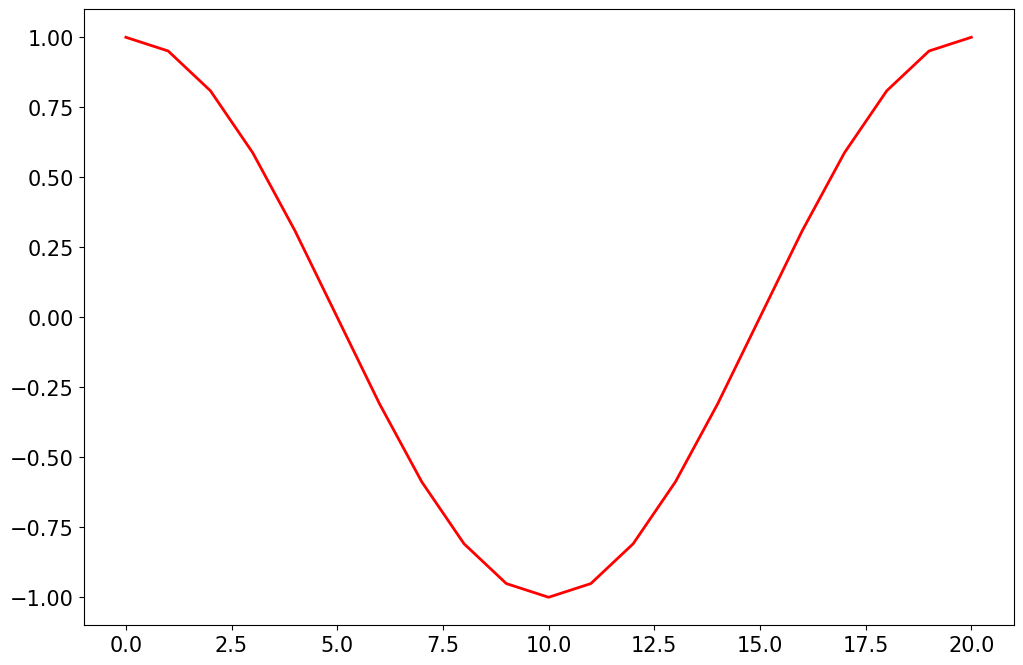

In [4]:
k = np.array(list(range(21)))
π = np.pi

def f(k):
    return np.cos(k*π/10)

print(f(k))

plt.figure(figsize=[12, 8])
plt.plot(k, f(k), c = "red")
plt.show()

# **Pairs Trading** #

**Cointegration:** Is it better to regress F on GM, or GM on F?  This is an open-ended question with no fixed correct answer. I want you to investigate, come to a conclusion, and defend it.

## Get Data & Ploting F and GM

In [5]:
F = pd.read_csv('F.csv')
GM = pd.read_csv('GM.csv')

ticker_F = "F"
ticker_GM = "GM"

color_F = "red"
color_GM = "blue"

F = F.set_index("Date", drop=True)
F.index = pd.to_datetime(F.index)
F = pd.Series(F["Adj Close"], name=ticker_F)

GM = GM.set_index("Date", drop=True)
GM.index = pd.to_datetime(GM.index)
GM = pd.Series(GM["Adj Close"], name=ticker_GM)

norF=pd.DataFrame(F/F[0])
norGM=pd.DataFrame(GM/GM[0])


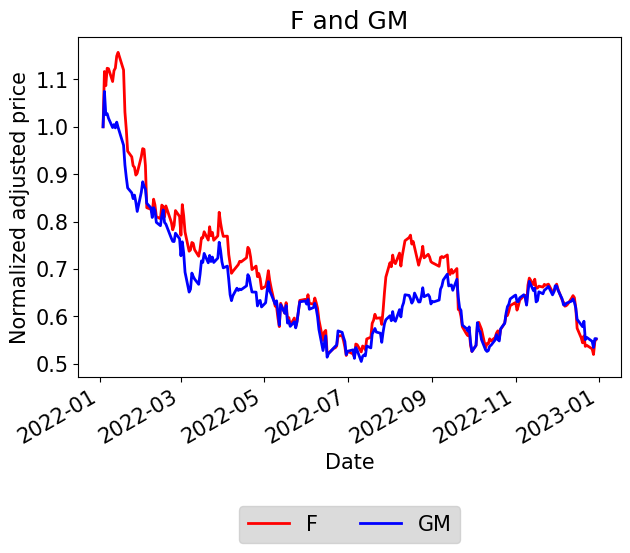

In [14]:
plt.figure(figsize=[7,5])
plt.plot(norF.index,norF,label=ticker_F,color=color_F)
plt.plot(norGM.index,norGM,label=ticker_GM,color=color_GM)
plt.ylabel("Normalized adjusted price")
plt.xlabel("Date")
plt.title(ticker_F+" and "+ticker_GM)
plt.gcf().autofmt_xdate()
legend("bottom",extra=True)
plt.show()

## Regression

Let's simply get their out-sample Mean-Square Error to see if there is huge gap. 

In [7]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

### Regressing F on GM

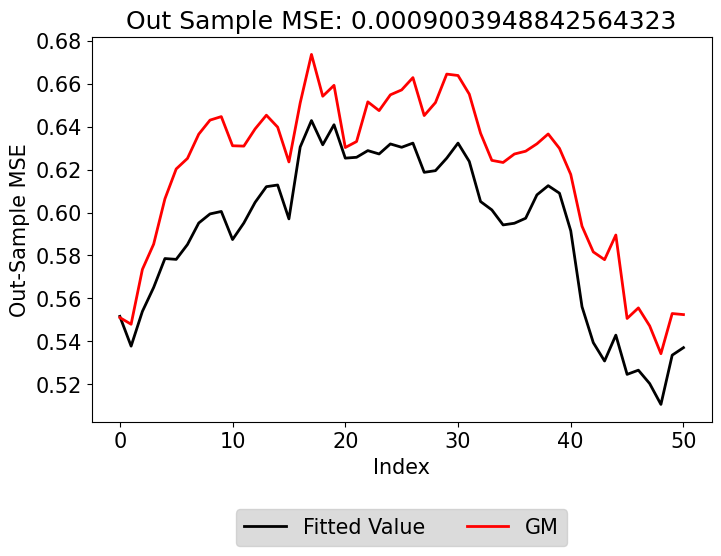

In [17]:
model1 = linear_model.LinearRegression(fit_intercept=True)

X_train1 = norF[:int(len(norF)*0.8)]
X_test1 = norF[int(len(norF)*0.8):]
y_train1 = norGM[:int(len(norF)*0.8)]
y_test1 = norGM[int(len(norF)*0.8):]

model1.fit(X_train1, y_train1)

fitv1 = model1.predict(X_test1)
MSE1 = mean_squared_error(fitv1, y_test1)
s1 = "Out Sample MSE: " + str(MSE1)

plt.figure(figsize=[8,5])
plt.title(s1)
plt.plot(fitv1, c = 'black', label = "Fitted Value")
plt.plot(y_test1.values, c = 'red', label = "GM")
plt.ylabel("Out-Sample MSE")
plt.xlabel("Index")
legend("bottom",extra=False)
plt.show()

### Regressing GM on F

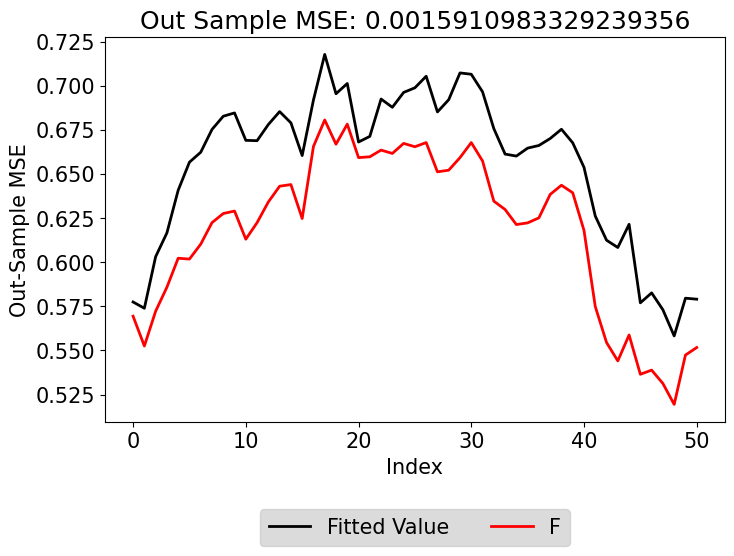

In [18]:
model2 = linear_model.LinearRegression(fit_intercept=True)

X_train2 = norGM[:int(len(norF)*0.8)]
X_test2 = norGM[int(len(norF)*0.8):]
y_train2 = norF[:int(len(norF)*0.8)]
y_test2 = norF[int(len(norF)*0.8):]

model2.fit(X_train2, y_train2)

fitv2 = model2.predict(X_test2)
MSE2 = mean_squared_error(fitv2, y_test2)
s2 = "Out Sample MSE: " + str(MSE2)

plt.figure(figsize=[8,5])
plt.title(s2)
plt.plot(fitv2, c = 'black', label = "Fitted Value")
plt.plot(y_test2.values, c = 'red', label = "F")
plt.ylabel("Out-Sample MSE")
plt.xlabel("Index")
legend("bottom",extra=False)
plt.show()

## Compare and Their Residual. 

In [10]:
print("Out Sample MSE of F regressing on GM: " + str(MSE1))
print("Out Sample MSE of GM regressing on F: " + str(MSE2))

Out Sample MSE of F regressing on GM: 0.0009003948842564323
Out Sample MSE of GM regressing on F: 0.0015910983329239356


From MSE, though there are difference, not significant. 
Let's then take a look at their absolute value of residual. 

In [11]:
r1 = abs(fitv1 - y_test1)
r2 = abs(fitv2 - y_test2)

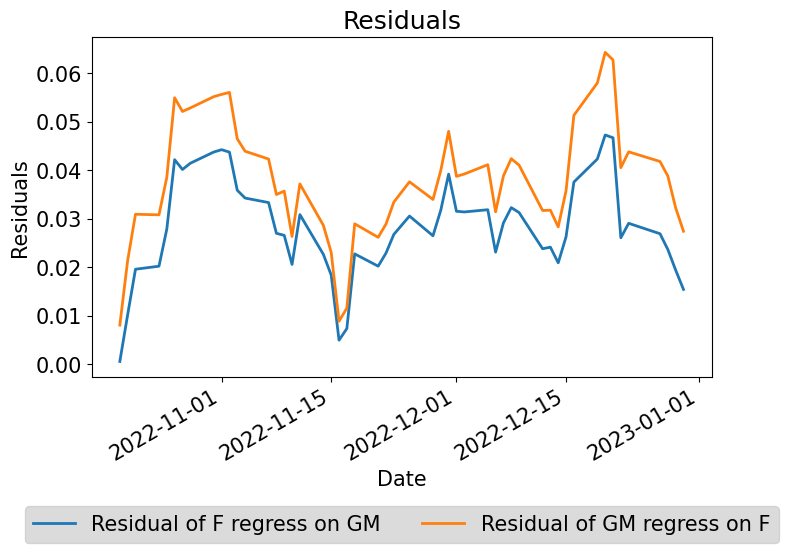

In [22]:
plt.figure(figsize=[8,5])
plt.plot(r1, label = "Residual of F regress on GM")
plt.plot(r2, label = "Residual of GM regress on F")
plt.title("Residuals")
plt.ylabel("Residuals")
plt.xlabel("Date")
plt.gcf().autofmt_xdate()
legend("bottom",extra=True)
plt.show()

We can see that residual of F regressing on GM is constantly smaller than that of GM regressing on F. 

## Conclusion

Though the difference in MSE is not quite significant, the residual of F regressing on GM is constantly lower than t hat of GM regressing of F. 
Thus, I would conclude that F regressing on GM is better. 

<img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250"/>